# 67658 Natural Language Processing
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Exercise 2
### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Asaf Shul 207042714
### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Daniel Azulay 311119895

initialize notebook:

In [1]:
# uncomment to download the module:
# !python -m spacy download en_core_web_sm

import nltk
# nltk.download('brown') # uncomment to download the module
from nltk.corpus import brown

import spacy
nlp = spacy.load("en_core_web_sm")

import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

from itertools import chain
from collections import Counter

from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

consts:

In [2]:
START       = 'START'
STOP        = 'STOP'
UNKNOWN_TAG = 'NN'
NOT_found   = -1

functions:

In [3]:
def add_start_stop(corpus):
    return [[(START, START)] + sent + [(STOP, STOP)] for sent in corpus]

def flatten(corpus):
    return list(chain.from_iterable(corpus))

def replace_word_tag(flat_corpus):
    return [(tag, word) for word, tag in flat_corpus]

def emission_setup(corpus):
    return replace_word_tag(flatten(add_start_stop(corpus)))

In [4]:
def get_tag_pairs(corpus):
    pairs = []

    for sent in corpus:
        sent = [START] + [tag for _, tag in sent] + [STOP]
        pairs.extend([p for p in zip(sent[:-1], sent[1:])])
    
    return pairs

In [5]:
def get_freq_dict(base_dict, norm=True, smooth=0):
    freq_dict = {}
    
    # format to freq dict:
    for key, count in base_dict.items():
        word, tag = key
        if word not in freq_dict:
            freq_dict[word] = {tag : count}
        elif tag not in freq_dict[word]:
            freq_dict[word][tag] = count
        else: 
            freq_dict[word][tag] += count
    
    if norm:
        # change count to relative probability:
        for word_counts in freq_dict.values():
            _N = sum(word_counts.values()) + len(word_counts) * smooth
            for key in word_counts:
#                 word_counts[key] = (word_counts[key] + smooth) / _N
                word_counts[key] = np.log((word_counts[key] + smooth) / _N)
    
    return freq_dict

In [6]:
def get_mle(train, test):
    unknown_words_dict = dict(Counter(chain.from_iterable(test)))
    freq_dict = get_freq_dict(dict(Counter(chain.from_iterable(train))), norm=False)
    res_dict  = {}
    
    # find the POS using MLE:
    for word, counts_dict in freq_dict.items():
        res_dict[word] = max(counts_dict, key=counts_dict.get)
    
    # add missing words:
    for word, _ in unknown_words_dict.keys():
        if word not in res_dict:
            res_dict[word] = UNKNOWN_TAG
    return res_dict

In [7]:
def get_emission(corpus, smooth=0):
    return pd.DataFrame(get_freq_dict(dict(Counter(emission_setup(corpus))), smooth=smooth)).fillna(-np.inf)

In [8]:
def get_transitions(train, smooth=0):
    return pd.DataFrame(get_freq_dict(dict(Counter(get_tag_pairs(train))), smooth=smooth)).fillna(-np.inf)

In [9]:
def clean_tag(w):
    p = w.find('+')
    m = w.find('-')
    n = len(w)
    return w[:min(p if p > 0 else n, m if m > 0 else n)]

In [10]:
def clean_corpus(corpus):
    return [[(word, clean_tag(tag)) for word, tag in sent] for sent in corpus]

In [11]:
def init_viterbi(tags, n):
    # initialize pi and bp
#     pi = pd.DataFrame(0, columns=tags, index=range(n-1))
#     pi.at[0, START] = 1
    
    pi = pd.DataFrame(-np.inf, columns=tags, index=range(n-1))
    pi.at[0, START] = 0

    bp = pd.DataFrame(np.nan, columns=tags, index=range(n-1))
    bp.loc[1] = START
    
    return pi, bp

In [12]:
def learn_viterbi(x, tags, n, pi, bp, transitions, emissions):
    tags_no_start = tags[1:]
    train_words = list(emissions.index)
        
    # dynamic array fill:
    pi.loc[1, transitions[START].keys()] = transitions[START]
    
    for k in range(2, n-1):
        word = x[k]
        known_word = (word in train_words)
        for curr_tag in tags_no_start:
            res = []
            cur_emission = emissions.at[word, curr_tag] if known_word else 0
            
            for prev_tag in tags_no_start:
                cur_transition = transitions.at[curr_tag, prev_tag]# if prev_known_word else 0
                p = pi.at[k-1, prev_tag] + cur_transition + cur_emission
                res.append((p, prev_tag))

            if res:
                res = sorted(res, key=lambda t: t[0], reverse=True)
                if res[0][0] != -np.inf:
                    pi.at[k, curr_tag] = res[0][0]
                    bp.at[k, curr_tag] = res[0][1]
                    
        if pi.loc[k].max() == -np.inf:
                pi.at[k, mle_model[word]] = 0
                bp.at[k, mle_model[word]] = pi.loc[k-1].idxmax()
    return pi, bp

In [13]:
def predict_viterbi(x, pi, bp):
    # prediction:
    pred = [(x[-2], pi.iloc[-1].idxmax())]
    for i, w in list(enumerate(x[1:-2]))[::-1]:
        pred.append((w, bp.loc[i+2, pred[-1][1]]))
        
    return pred[::-1]

In [14]:
def viterbi(sent, transitions, emissions):
    # initialize:
    x = [START] + sent + [STOP]
    n = len(x)
    tags = list(transitions.keys())
    train_words = list(emissions.index)
    
    pi, bp = init_viterbi(tags, n)    
    pi, bp = learn_viterbi(x, tags, n, pi, bp, transitions, emissions)
    return predict_viterbi(x, pi, bp)

In [15]:
def mle_error_rate(corpus, model):
    return round(1 - sum([1 for (w, t) in corpus if model[w] == t]) / len(corpus), 5)

In [57]:
def hmm_error_rate(test, emissions, transitions):
    known_succ = 0
    unknown_succ = 0
    known_guess = 0
    unknown_guess = 0
    
    unknown_words_words = [w for w, _ in unknown_words]
    
    for i, sent in enumerate(test):    
        print('.', end='')
        preds = viterbi([w for w, _ in sent], transitions, emissions)
        
        for p in zip(sent, preds):
            if p[0][0] in unknown_words_words:
                unknown_succ += p[0] == p[1]
                unknown_guess += 1
            else: 
                known_succ += p[0] == p[1]
                known_guess += 1
    print()
    return (round(1 - ((known_succ + unknown_succ) / (known_guess + unknown_guess)), 5),
            round(1 - (known_succ / known_guess), 5),
            (round(1 - (unknown_succ / unknown_guess), 5)) if unknown_guess else np.nan)

results:

### initialize data:

In [17]:
# get data:
tagged = clean_corpus(brown.tagged_sents(categories="news"))
train, test = train_test_split(tagged, test_size=0.1, shuffle=False)

**a) create MLE:**

In [18]:
%%time
mle_model = get_mle(train, test)

CPU times: user 19.4 ms, sys: 1.31 ms, total: 20.8 ms
Wall time: 20.2 ms


**b) MLE accuracy:**

In [19]:
f_train = flatten(train)
f_test = flatten(test)

f_train_words = [w for w, _ in flatten(train)]
f_test_words = [w for w, _ in flatten(test)]

known_words = [(w, t) for w, t in f_test if w in f_train_words]
unknown_words = [(w, t) for w, t in f_test if w not in f_train_words]

In [20]:
# calc accuracy:
print(f'Error rate using MLE:')
print(f'----------------------------------')
print(f'  - total words is   {mle_error_rate(flatten(test), mle_model)}')
print(f'----------------------------------')
print(f'  - known words is   {mle_error_rate(known_words, mle_model)}')
print(f'  - unknown words is {mle_error_rate(unknown_words, mle_model)}')
print(f'----------------------------------')

Error rate using MLE:
----------------------------------
  - total words is   0.14811
----------------------------------
  - known words is   0.07044
  - unknown words is 0.75044
----------------------------------


**c) HMM:**

In [21]:
emissions = get_emission(train)
transitions = get_transitions(train)

In [22]:
total_error, known_error, unknown_error = hmm_error_rate(test, emissions, transitions)
# calc accuracy:
print(f'Error rate using HMM:')
print(f'----------------------------------')
print(f'  - total words is   {total_error}')
print(f'----------------------------------')
print(f'  - known words is   {known_error}')
print(f'  - unknown words is {unknown_error}')
print(f'----------------------------------')

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Error rate using HMM:
----------------------------------
  - total words is   0.13635
----------------------------------
  - known words is   0.06301
  - unknown words is 0.70506
----------------------------------


**d) HMM: add-1 smothing**

In [23]:
smooth_emissions = get_emission(train, smooth=1)
smooth_transitions = get_transitions(train, smooth=1)

In [24]:
total_error, known_error, unknown_error = hmm_error_rate(test, smooth_emissions, smooth_transitions)
# calc accuracy:
print(f'Error rate using HMM + add-1 smoothing:')
print(f'----------------------------------')
print(f'  - total words is   {total_error}')
print(f'----------------------------------')
print(f'  - known words is   {known_error}')
print(f'  - unknown words is {unknown_error}')
print(f'----------------------------------')

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Error rate using HMM + add-1 smoothing:
----------------------------------
  - total words is   0.13575
----------------------------------
  - known words is   0.06211
  - unknown words is 0.70681
----------------------------------


**d) HMM: Psuedo Words**

In [50]:
f_test = [w for (w, _) in flatten(test)]
f_train = [w for (w, _) in flatten(train)]
unknown = pd.Series(1, index=[w for w in f_test if w not in f_train])

counts = pd.Series(Counter(f_train))
counts = counts[counts <= 5]

counts = pd.concat([counts, unknown])

years = counts[(counts.index.str.isdigit()) & (counts.index.str.len() == 4)].index
counts = counts[~counts.index.isin(years)]

quantity = counts[(((counts.index.str.replace(',', '')).str.replace('.', '')).str.isdigit())].index
counts = counts[~counts.index.isin(quantity)]

price = counts[(counts.index.str.contains('\$')) & (counts.index.str.len() > 1)].index
counts = counts[~counts.index.isin(price)]

precentage = counts[(counts.index.str.contains('\%')) & (counts.index.str.len() > 1)].index
counts = counts[~counts.index.isin(precentage)]

acronyms = counts[(counts.index.str.isupper()) & counts.index.str.replace('.', '').str.isalpha() & (counts.index.str.len() > 1)].index
counts = counts[~counts.index.isin(acronyms)]

letter = counts[(counts.index.str.isalpha()) & (counts.index.str.len() == 1) & (counts.index != 'a') & (counts.index != 'I')].index
counts = counts[~counts.index.isin(letter)]

possession = counts[(counts.index.str.endswith("'s"))].index
counts = counts[~counts.index.isin(possession)]

rank = counts[(counts.index.str.endswith("th") | counts.index.str.endswith("st") |\
              counts.index.str.endswith("nd") | counts.index.str.endswith("rd")) & \
              (counts.index.str[:-2].str.isdigit())].index
counts = counts[~counts.index.isin(rank)]

short = counts[counts.index.str.endswith('.')].index
counts = counts[~counts.index.isin(short)]

date = counts[counts.index.str.replace('-', '').str.replace('/', '').str.isdigit() & counts.index.str.contains('-')].index
counts = counts[~counts.index.isin(date)]

time = counts[counts.index.str.replace(':', '').str.isdigit() & counts.index.str.contains(':')].index
counts = counts[~counts.index.isin(time)]

units = counts[counts.index.str[-1].str.isalpha() & counts.index.str[0].str.isdigit()].index
counts = counts[~counts.index.isin(units)]

dash = counts[counts.index.str.replace('-', '').str.isalpha() & counts.index.str.contains('-')].index
counts = counts[~counts.index.isin(dash)]

ly = counts[counts.index.str.endswith('ly')].index
counts = counts[~counts.index.isin(ly)]

ing = counts[counts.index.str.endswith('ing')].index
counts = counts[~counts.index.isin(ing)]

ion = counts[counts.index.str.endswith('ion')].index
counts = counts[~counts.index.isin(ion)]

ed = counts[counts.index.str.endswith('ed')].index
counts = counts[~counts.index.isin(ed)]

ment = counts[counts.index.str.endswith('ment')].index
counts = counts[~counts.index.isin(ment)]

er = counts[counts.index.str.endswith('er')].index
counts = counts[~counts.index.isin(er)]

tory = counts[counts.index.str.endswith('tory')].index
counts = counts[~counts.index.isin(tory)]

nt = counts[counts.index.str.endswith("n't")].index
counts = counts[~counts.index.isin(nt)]

init_cap = counts[counts.index.str[0].str.isupper()].index
counts = counts[~counts.index.isin(init_cap)]

lower = counts[counts.index.str.islower() & counts.index.str.isalpha()].index
counts = counts[~counts.index.isin(lower)]

misc = counts.index


code_dict = \
{('*years*', '*years-tag*') : years,
 ('*quantity*', '*quantity-tag*') : quantity,
 ('*price*', '*price-tag*') : price,
 ('*precentage*', '*precentage-tag*') : precentage,
 ('*acronyms*', '*acronyms-tag*') : acronyms,
 ('*letter*', '*letter-tag*') : letter,
 ('*possession*', '*possession-tag*') : possession,
 ('*rank*', '*rank-tag*') : rank,
 ('*short*', '*short-tag*') : short,
 ('*date*', '*date-tag*') : date,
 ('*time*', '*time-tag*') : time,
 ('*units*', '*units-tag*') : units,
 ('*dash*', '*dash-tag*') : dash,
 ('*ly*', '*ly-tag*') : ly,
 ('*ing*', '*ing-tag*') : ing,
 ('*ion*', '*ion-tag*') : ion,
 ('*ed*', '*ed-tag*') : ed,
 ('*ment*', '*ment-tag*') : ment,
 ('*er*', '*er-tag*') : er,
 ('*tory*', '*tory-tag*') : tory,
 ('*nt*', '*nt-tag*') : nt,
 ('*years*', '*years-tag*') : years,
 ('*init_cap*', '*init_cap-tag*') : init_cap,
 ('*lower*', '*lower-tag*') : lower,
 ('*misc*', '*misc-tag*') : misc}

def replace_rare(w, t):
    for code, lst in code_dict.items():
        if w in lst:
            return code
    return (w, t)


In [51]:
psuedo = deepcopy(tagged)

for i in range(len(psuedo)):
    for j in range(len(psuedo[i])):
        psuedo[i][j] = replace_rare(*psuedo[i][j])

p_train, p_test = train_test_split(psuedo, test_size=0.1, shuffle=False)

In [59]:
psuedo_emissions = get_emission(p_train)
psuedo_transitions = get_transitions(p_train)

In [60]:
mle_model = get_mle(p_train, p_test)

In [62]:
total_error, known_error, unknown_error = hmm_error_rate(p_test, psuedo_emissions, psuedo_transitions)
# calc accuracy:
print(f'Error rate using HMM + psuedo words:')
print(f'----------------------------------')
print(f'  - total words is   {total_error}')
print(f'----------------------------------')
print(f'  - known words is   {known_error}')
print(f'  - unknown words is {unknown_error}')
print(f'----------------------------------')

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Error rate using HMM + psuedo words:
----------------------------------
  - total words is   0.05332
----------------------------------
  - known words is   0.05332
  - unknown words is nan
----------------------------------


In [63]:
smooth_psuedo_emissions = get_emission(p_train, smooth=1)
smooth_psuedo_transitions = get_transitions(p_train, smooth=1)

In [64]:
total_error, known_error, unknown_error = hmm_error_rate(p_test, smooth_psuedo_emissions,
                                                         smooth_psuedo_transitions)
# calc accuracy:
print(f'Error rate using HMM + psuedo words + add-1 smoothing:')
print(f'----------------------------------')
print(f'  - total words is   {total_error}')
print(f'----------------------------------')
print(f'  - known words is   {known_error}')
print(f'  - unknown words is {unknown_error}')
print(f'----------------------------------')

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Error rate using HMM + psuedo words + add-1 smoothing:
----------------------------------
  - total words is   0.05342
----------------------------------
  - known words is   0.05342
  - unknown words is nan
----------------------------------


**Confusion matrix**

In [65]:
preds = []
labels = []
ticks = set()
for sent in test:
    print('.', end='')
    sent_pred = viterbi([w for w, _ in sent], smooth_psuedo_transitions, smooth_psuedo_emissions)
    preds.extend([p for (_, p) in sent_pred])
    labels.extend([l for (_, l) in sent])
    ticks = ticks.union(set(labels)).union(set(preds))
print()


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................


<AxesSubplot: >

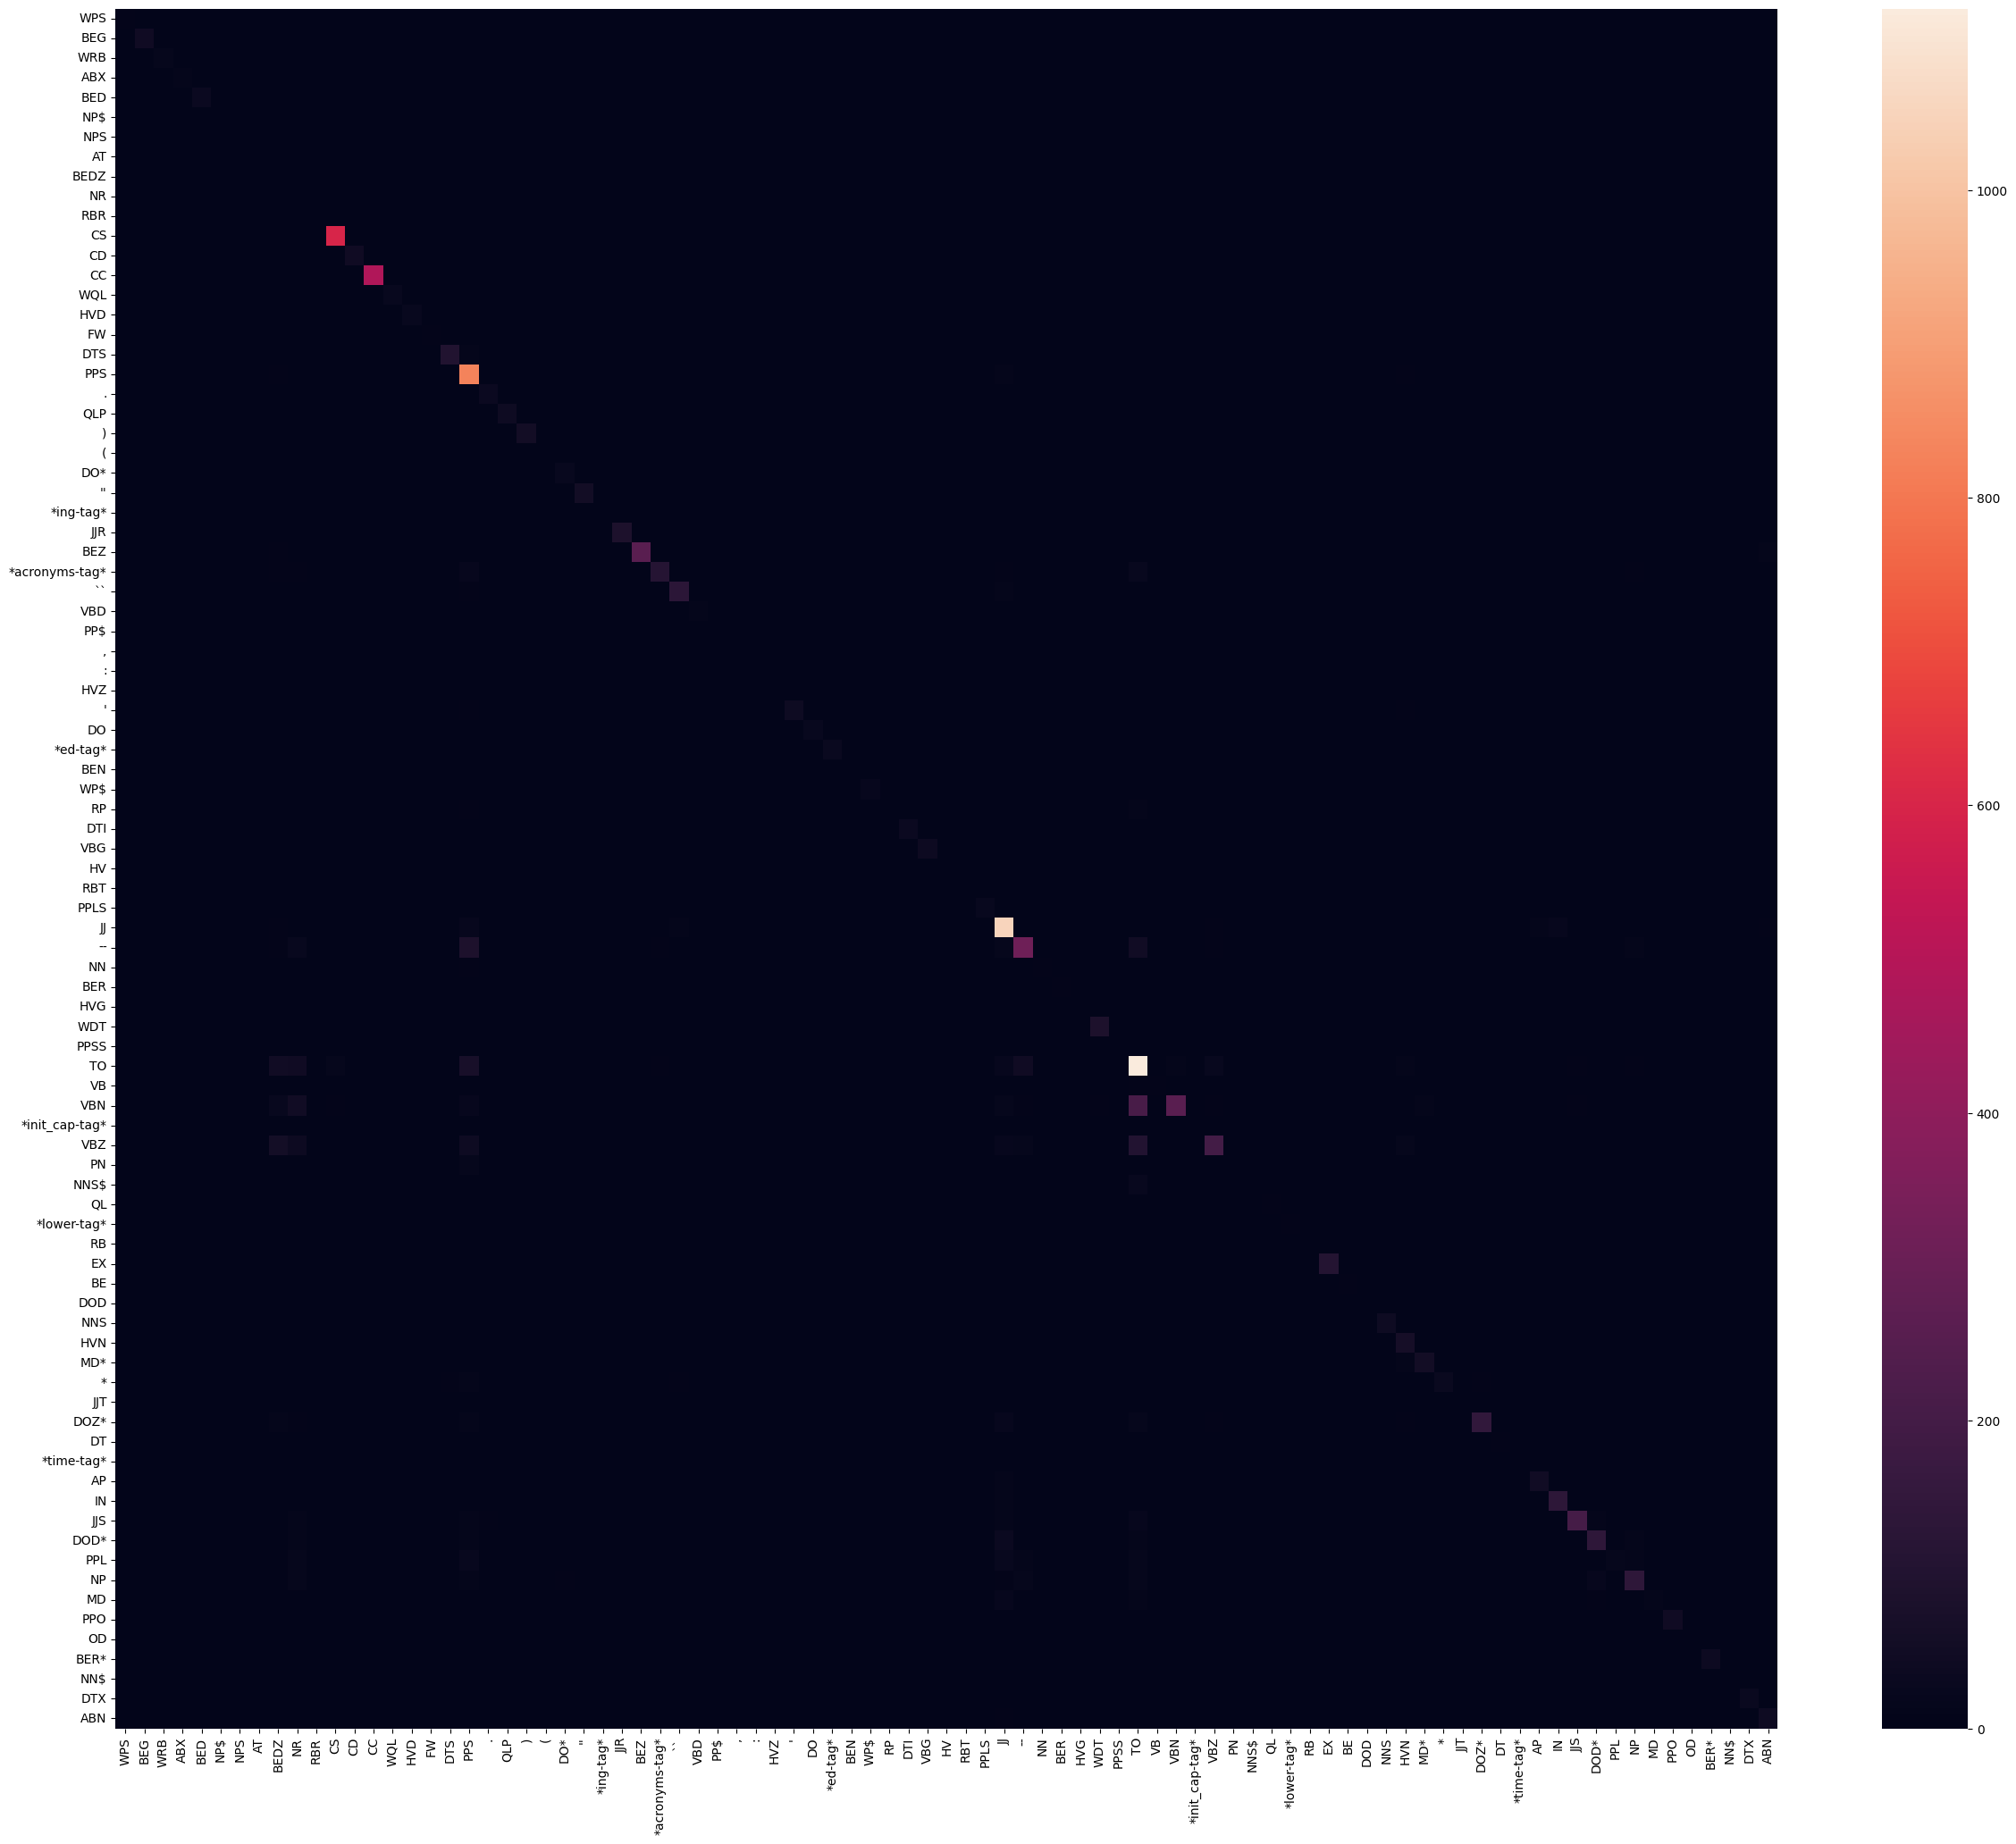

In [66]:
plt.figure(figsize=(30, 25))
sns.heatmap(confusion_matrix(labels, preds), xticklabels=ticks, yticklabels=ticks)